In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [13]:
%autoreload

cohort = mre_pinn.data.PatientCohort(xarray_dir='../data/NAFLD', patient_ids='0006')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
100%|██████████| 1/1 [00:00<00:00, 50.68it/s]


In [14]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [53]:
%autoreload

pino = mre_pinn.model.pino.SpectralAttention(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_modes=128
)
pino

SpectralAttention(n_spatial_dims=3, n_channels_in=4, n_channels_out=1, n_modes=128)

In [54]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000190 s



Training model...

Step      Train loss              Test loss               Test metric
0         [1.04e-05, 1.04e+03]    [1.04e-05, 1.04e+03]    []  


<IPython.core.display.Javascript object>


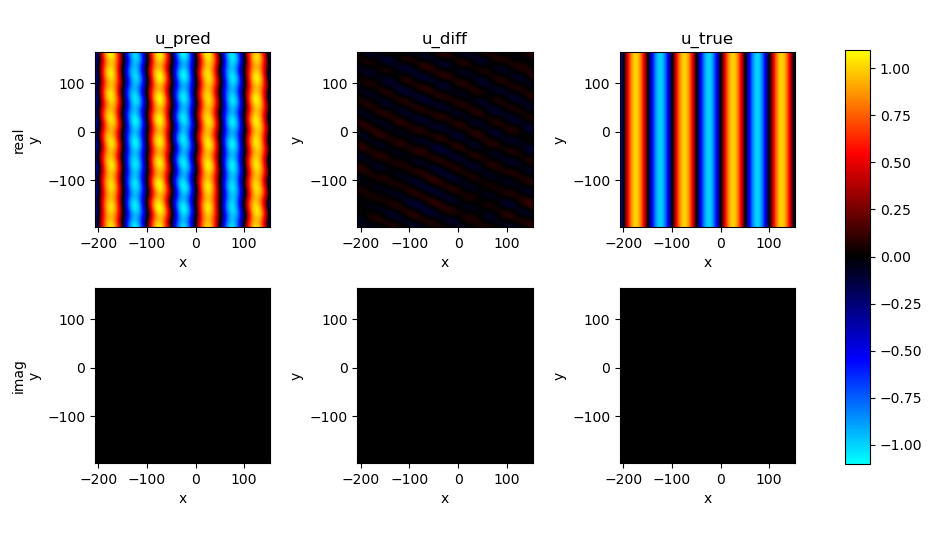

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 17.10%
10        [4.00e-07, 4.00e+01]    [4.00e-07, 4.00e+01]    []  
Time spent testing: 14.81%
20        [1.31e-07, 1.31e+01]    [1.31e-07, 1.31e+01]    []  
Time spent testing: 14.10%
30        [3.19e-08, 3.19e+00]    [3.19e-08, 3.19e+00]    []  
Time spent testing: 13.73%
40        [1.02e-08, 1.02e+00]    [1.02e-08, 1.02e+00]    []  
Time spent testing: 13.54%
50        [4.11e-09, 4.11e-01]    [4.11e-09, 4.11e-01]    []  
Time spent testing: 13.43%
60        [1.60e-09, 1.60e-01]    [1.60e-09, 1.60e-01]    []  
Time spent testing: 13.34%
70        [7.81e-10, 7.81e-02]    [7.81e-10, 7.81e-02]    []  
Time spent testing: 13.26%
80        [3.75e-10, 3.75e-02]    [3.75e-10, 3.75e-02]    []  
Time spent testing: 13.20%
90        [2.41e-10, 2.41e-02]    [2.41e-10, 2.41e-02]    []  
Time spent testing: 13.15%
100       [1.78e-10, 1.78e-02]    [1.78e-10, 1.78e-02]    []  
Time spent testing: 13.11%
110       [1.50e-10, 1.50e-02]    [1.50e-10, 1.50e-02]    []  
Time spent

920       [2.15e-11, 2.15e-03]    [2.15e-11, 2.15e-03]    []  
Time spent testing: 12.60%
930       [2.22e-11, 2.22e-03]    [2.22e-11, 2.22e-03]    []  
Time spent testing: 12.60%
940       [6.67e-11, 6.67e-03]    [6.67e-11, 6.67e-03]    []  
Time spent testing: 12.60%
950       [3.72e-10, 3.72e-02]    [3.72e-10, 3.72e-02]    []  
Time spent testing: 12.60%
960       [4.11e-11, 4.11e-03]    [4.11e-11, 4.11e-03]    []  
Time spent testing: 12.60%
970       [3.16e-11, 3.16e-03]    [3.16e-11, 3.16e-03]    []  
Time spent testing: 12.60%
980       [2.20e-11, 2.20e-03]    [2.20e-11, 2.20e-03]    []  
Time spent testing: 12.59%
990       [1.68e-11, 1.68e-03]    [1.68e-11, 1.68e-03]    []  
Time spent testing: 12.59%
1000      [1.54e-11, 1.54e-03]    [1.54e-11, 1.54e-03]    []  

Best model at step 1000:
  train loss: 1.54e-03
  test loss: 1.54e-03
  test metric: []

'train' took 201.122267 s



(<deepxde.model.LossHistory at 0x151062467a90>,
 <deepxde.model.TrainState at 0x150fe690ab90>)

In [55]:
model.train(1000, display_every=10, callbacks=[test_eval])